In [9]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from scipy import io
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

In [10]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

In [11]:
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.bounding_box import BoxList
from predictor import COCODemo
config_file = "../configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

In [12]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0,
)
file_dir = '/home/yxy/yxy_workspace/pop/popTestImages'

In [13]:
def load(path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    pil_image = Image.open(path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.figure()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()

In [14]:
def boxlist_nms(boxlist, nms_thresh=0.5, max_proposals=-1, score_field="scores"):
    """
    Performs non-maximum suppression on a boxlist, with scores specified
    in a boxlist field via score_field.

    Arguments:
        boxlist(BoxList)
        nms_thresh (float)
        max_proposals (int): if > 0, then only the top max_proposals are kept
            after non-maximum suppression
        score_field (str)
    """
    if nms_thresh <= 0:
        return boxlist
    mode = boxlist.mode
    boxlist = boxlist.convert("xyxy")
    boxes = boxlist.bbox
    score = boxlist.get_field(score_field)
    keep,picked_score = nms(boxes, score, nms_thresh)
    if max_proposals > 0:
        keep = keep[: max_proposals]
    boxlist = boxlist[keep]
    return boxlist.convert(mode)

"""
    Non-max Suppression Algorithm
    @param list  Object candidate bounding boxes
    @param list  Confidence score of bounding boxes
    @param float IoU threshold
    @return Rest boxes after nms operation
"""
def nms_candidate(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)
    
    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)
    candidates = []
    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)
        
        nonleft = np.where(ratio >= threshold)
        
        candidate = np.append(order[nonleft],index)

        candidates.append(candidate)
        
        left = np.where(ratio < threshold)
        order = order[left]

    return candidates

"""
    Non-max Suppression Algorithm
    @param list  Object candidate bounding boxes
    @param list  Confidence score of bounding boxes
    @param float IoU threshold
    @return Rest boxes after nms operation
"""
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(index)
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

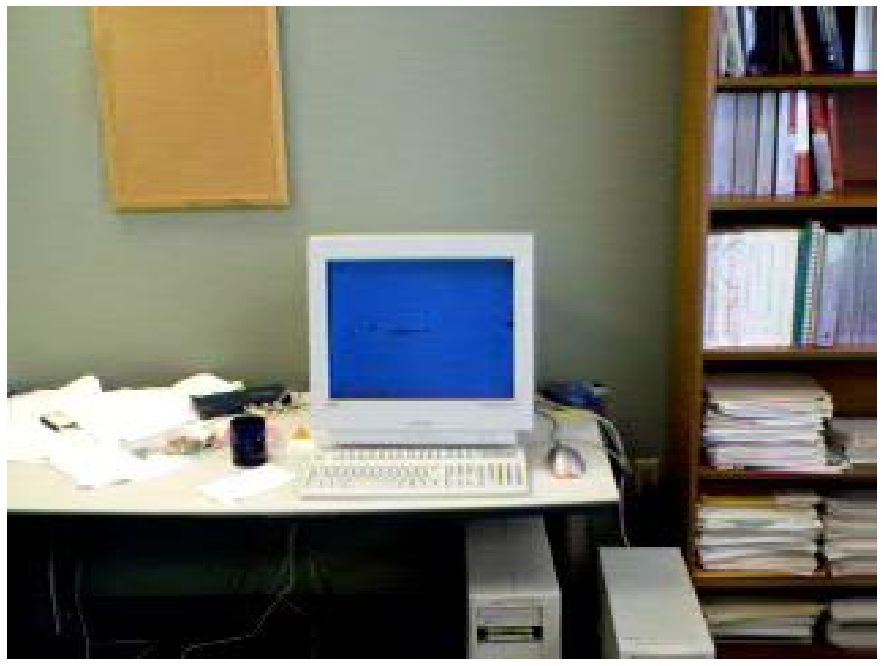

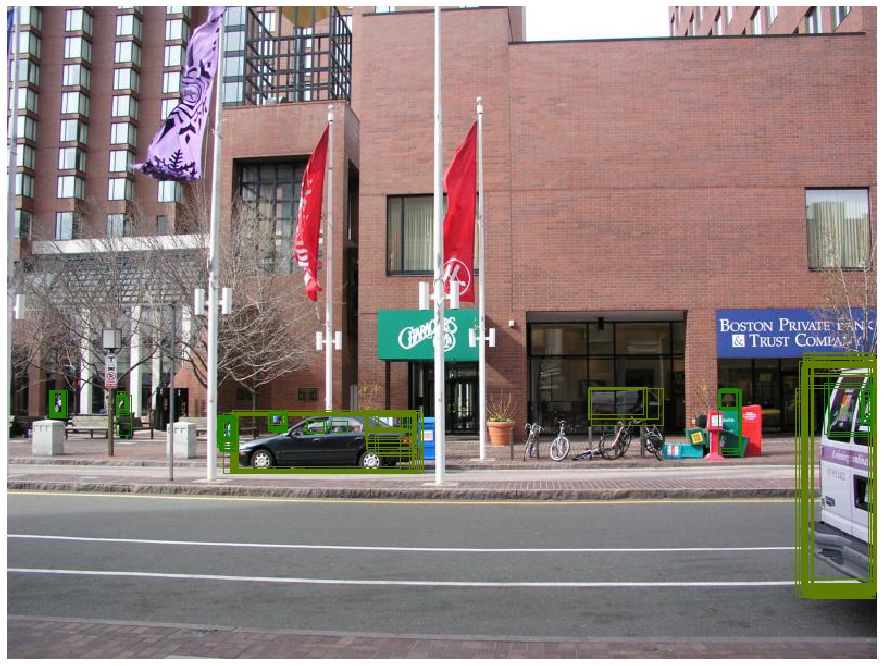

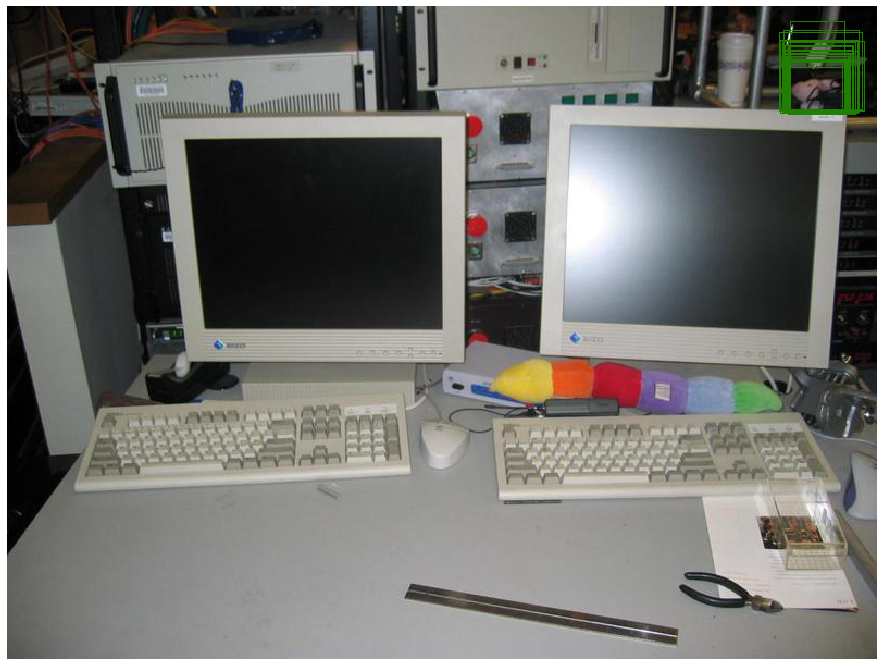

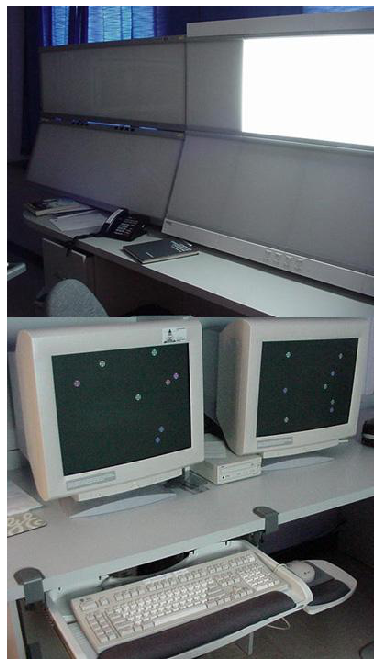

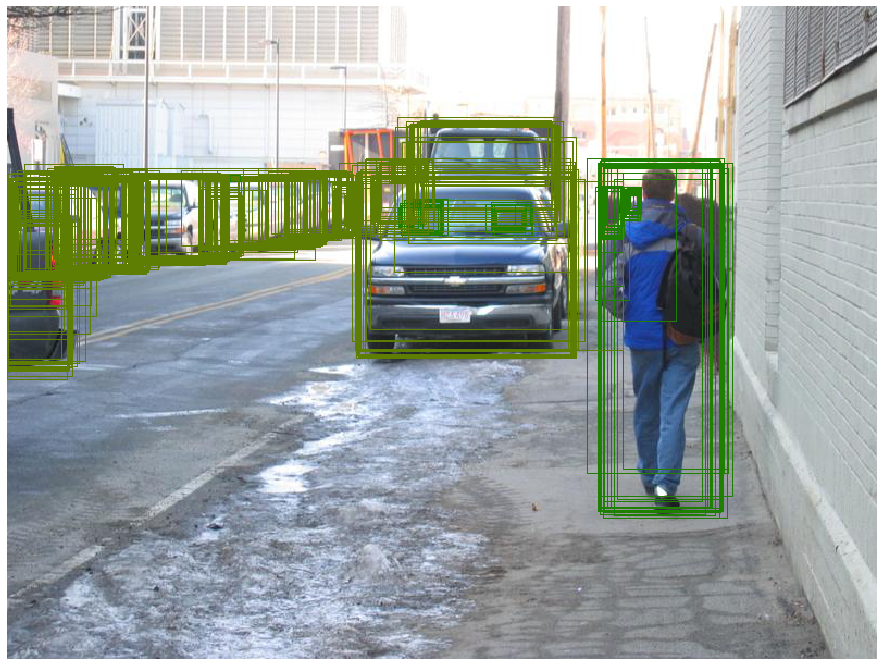

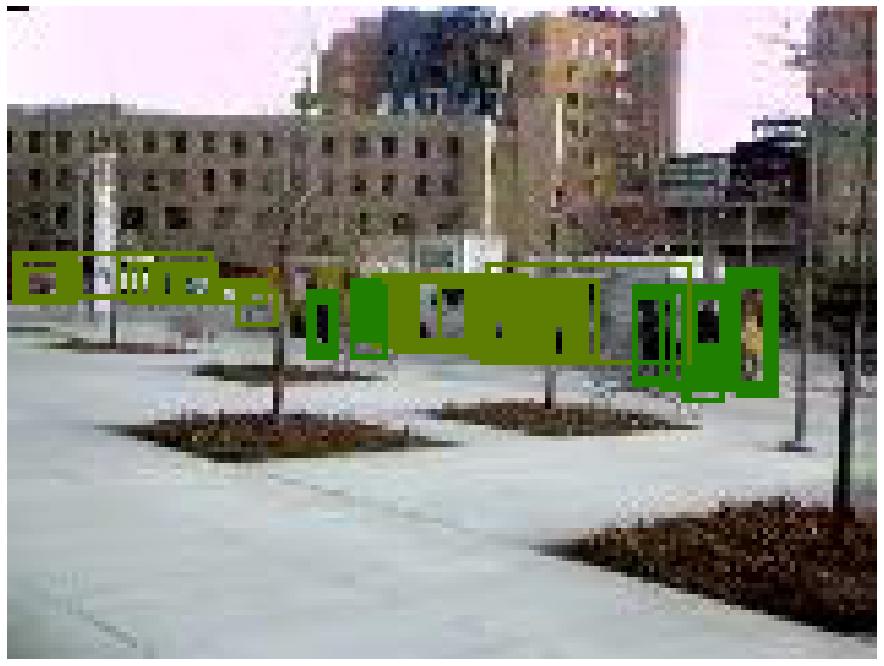

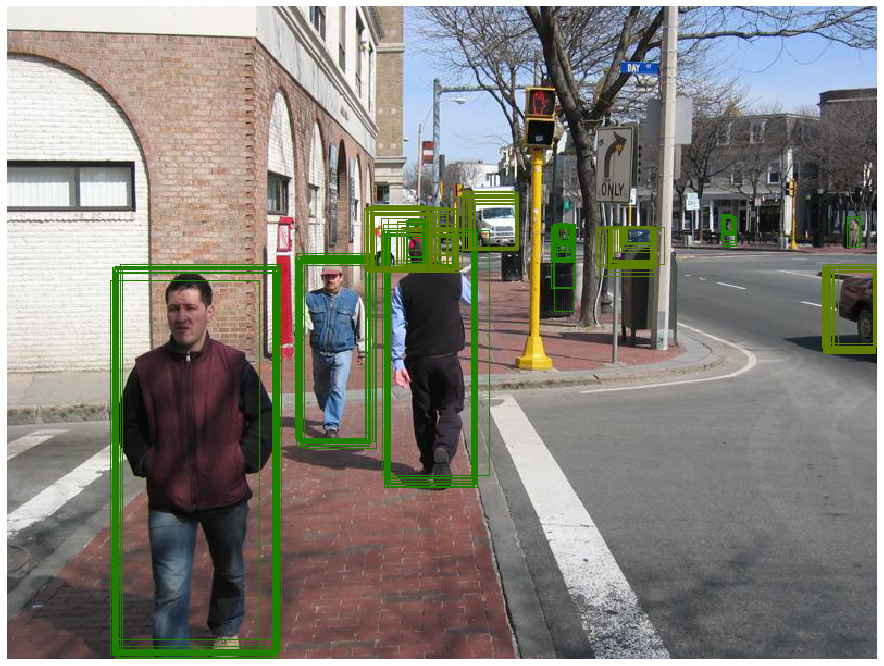

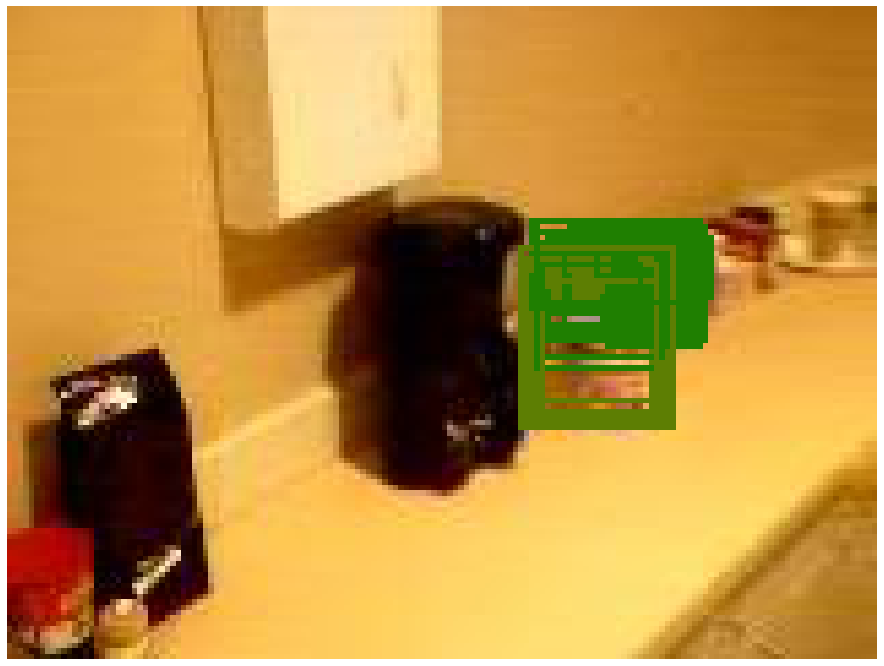

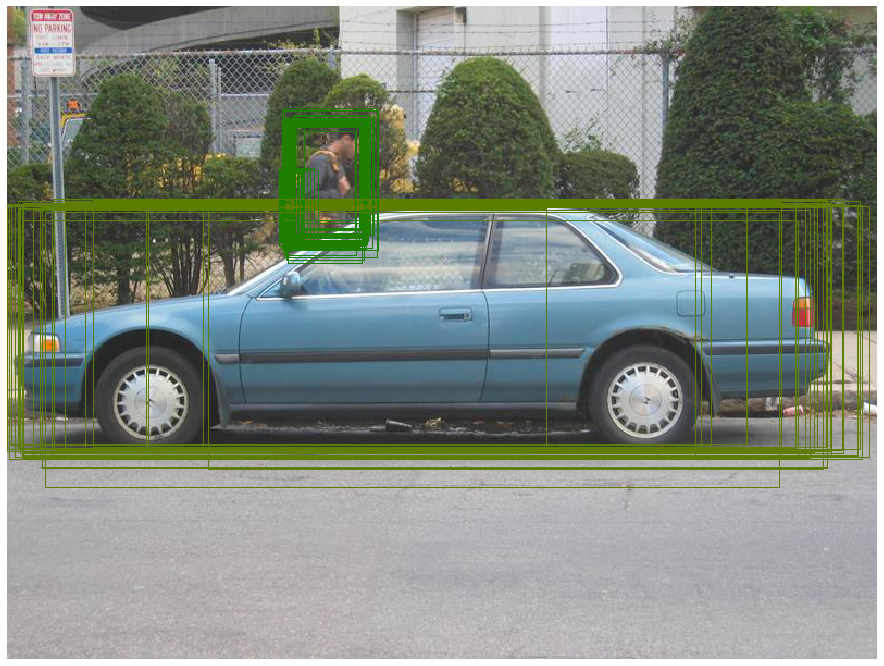

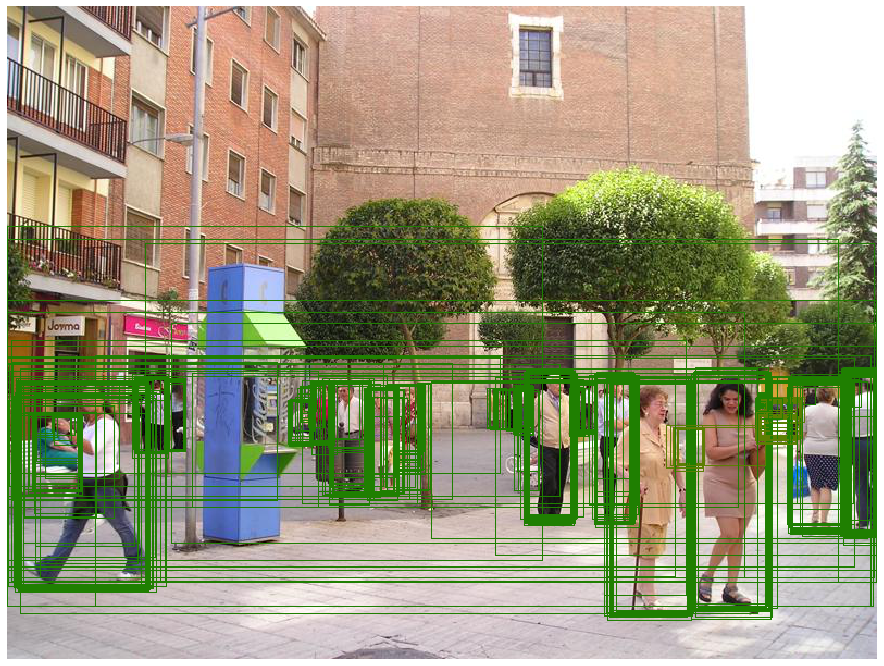

In [73]:

for fn in os.listdir(file_dir)[:10]:
    img_file = os.path.join(file_dir,fn)
    image = load(img_file)

    predictions = coco_demo.run_on_opencv_image(image)
    imshow(predictions)

In [15]:
# Show nms candidates images with car and people
file_list = io.loadmat('popTestset.mat')

cand_list=[]
# for fn in tqdm(os.listdir(file_dir)):
for i in tqdm(range(600)):
    fn = file_list['ts']['imnames'][0,0][0,i][0]
    img_file = os.path.join(file_dir,fn)
    # print(img_file)
    image = load(img_file)
    predictions = coco_demo.compute_prediction(image)
    predictions = coco_demo.select_top_predictions(predictions)
    boxes = predictions.bbox
    scores = predictions.get_field("scores")
    label = predictions.get_field("labels")
    cand_dict_list = []
    for j in [1,3,6,8]:
        cls_index = np.where(label==j)
        scores_class = scores[cls_index]
        boxes_class = boxes[cls_index]
        candidates = nms_candidate(boxes_class, scores_class, 0.33)
        for cand in candidates:
            boxlist_for_cand = predictions[cls_index[0][cand]]
            score_for_cand = np.array(boxlist_for_cand.get_field("scores"))
            boxes_for_cand = np.array(boxlist_for_cand.bbox)
            cand_dict = {
                         "conf":score_for_cand.T,
                         "bbox":boxes_for_cand,
                         "p":np.max(score_for_cand),
                         "ObjType":j
                        }
            cand_dict_list.append(cand_dict)
    cand_list.append(np.array(cand_dict_list))
io.savemat('candidate.mat', mdict={'candidate': np.array(cand_list)})

100%|██████████| 600/600 [19:55<00:00,  1.99s/it]


In [ ]:
# Show nms images with car and people
for fn in os.listdir(file_dir)[:20]:
    img_file = os.path.join(file_dir,fn)
    image = load(img_file)
    predictions = coco_demo.compute_prediction(image)
    predictions = coco_demo.select_top_predictions(predictions)
    boxes = predictions.bbox
    scores = predictions.get_field("scores")
    label = predictions.get_field("labels")
    for j in [1,3]:
        cls_index = np.where(label==j)
        scores_class = scores[cls_index]
        boxes_class = boxes[cls_index]
        keep,picked_score = nms(boxes_class, scores_class, 0.5)
        boxlist_for_class = predictions[cls_index[0][keep]]
        result = image.copy()
        result = coco_demo.overlay_boxes(result, boxlist_for_class)
        imshow(result)

In [13]:
file_list = io.loadmat('popTestset.mat')
for name in file_list['ts']['imnames'][0,0]:
    print(str(name))

IndexError: too many indices for array

'p1010239.jpg'